In [25]:
import os

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from monai.transforms import (
    Resize,
    Compose,
    LoadImage,
    ScaleIntensity,
    EnsureChannelFirst,
    RandRotate,
    RandFlip,
)
from monai.networks.nets import DenseNet121
from monai.metrics import ROCAUCMetric
from monai.utils import set_determinism


## Предобработка и балансировка датасета

### Загрузка датасета

In [59]:
train_df = pd.read_excel(r'train/train.xlsx', index_col=0)
# измение строк с путями
train_df['image_path'] = train_df['image_path'].str.replace('\\', '/')
train_df['annotation_path_label'] = train_df['annotation_path_label'].str.replace('\\', '/')

print(f'Количество исследований: {len(train_df)}')
train_df.head()

Количество исследований: 384


,ID,image_path,annotation_path_label,pathology
0,image_393.jpg,train/images/image_393.jpg,train/annotation/annotation_393.json,1
1,image_326.jpg,train/images/image_326.jpg,train/annotation/annotation_326.json,1
2,image_290.jpg,train/images/image_290.jpg,train/annotation/annotation_290.json,1
3,image_206.jpg,train/images/image_206.jpg,train/annotation/annotation_206.json,1
4,image_429.jpg,train/images/image_429.jpg,train/annotation/annotation_429.json,0


### Удаление экземпляров не имеющих bbox и 217 исследование с некорректным json

In [65]:
def has_annotation_bbox(annotaion_path):
    with open(annotaion_path, 'r') as f:
            data = json.load(f)
            data = data['annotations'][0]
            has_bbox = 'bbox' in data
            return has_bbox
    
def del_element_without_bbjljbhkhox(df):
    count = 0
    for idx, annotation_path in enumerate(df['annotation_path_label']):
        print(annotation_path)
        # try:
        if has_annotation_bbox(annotation_path):
                return count
        # except:
        #     print(idx)

def del_element_without_bbox(df):
    for idx, annotion_path in enumerate(df['annotation_path_label']):
        try:
            if has_annotation_bbox(annotion_path):
                df.drop(index=idx)
        except:
            print(f'В json {annotion_path} ошибка из-за некорректной записи')
    return df
    

train_df = del_element_without_bbox(train_df)
print(f'Количество исследований: {len(train_df)}')
train_df

В json label: 0 (norma) ошибка из-за некорректной записи
Количество исследований: 122


,ID,image_path,annotation_path_label,pathology
4,image_429.jpg,train/images/image_429.jpg,train/annotation/annotation_429.json,0
6,image_435.jpg,train/images/image_435.jpg,train/annotation/annotation_435.json,0
7,image_542.jpg,train/images/image_542.jpg,train/annotation/annotation_542.json,0
11,image_523.jpg,train/images/image_523.jpg,train/annotation/annotation_523.json,0
14,image_515.jpg,train/images/image_515.jpg,train/annotation/annotation_515.json,0
...,...,...,...,...
375,image_518.jpg,train/images/image_518.jpg,train/annotation/annotation_518.json,0
377,image_388.jpg,train/images/image_388.jpg,train/annotation/annotation_388.json,0
379,image_399.jpg,train/images/image_399.jpg,train/annotation/annotation_399.json,0
380,image_295.jpg,train/images/image_295.jpg,train/annotation/annotation_295.json,0


In [67]:
filtered_df = train_df[train_df['pathology'] == 1]
filtered_df

,ID,image_path,annotation_path_label,pathology


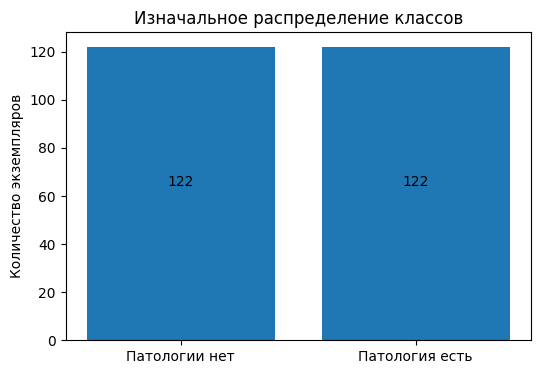

In [64]:
from utils import visualize_distribution

visualize_distribution(train_df)

In [6]:
class SpinaBifidaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        json_path = self.dataframe.iloc[idx]['annotation_path_label']
        label = self.dataframe.iloc[idx]['class']

        # Загрузка изображения
        image = Image.open(img_path)
        
        # Загрузка bbox из JSON
        with open(json_path, 'r') as f:
            bbox_data = json.load(f)
        bbox = bbox_data['annotations'][0]['bbox']

        # Обрезка изображения по bbox
        image = image.crop((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))

        # Применение трансформаций
        if self.transform:
            image = self.transform(image)

        return image, label


In [37]:
df = pd.read_excel(r'train/train.xlsx')
df[:10]

,Unnamed: 0,ID,image_path,annotation_path_label,pathology
0,0,image_393.jpg,train\images\image_393.jpg,train\annotation\annotation_393.json,1
1,1,image_326.jpg,train\images\image_326.jpg,train\annotation\annotation_326.json,1
2,2,image_290.jpg,train\images\image_290.jpg,train\annotation\annotation_290.json,1
3,3,image_206.jpg,train\images\image_206.jpg,train\annotation\annotation_206.json,1
4,4,image_429.jpg,train\images\image_429.jpg,train\annotation\annotation_429.json,0
5,5,image_252.jpg,train\images\image_252.jpg,train\annotation\annotation_252.json,1
6,6,image_435.jpg,train\images\image_435.jpg,train\annotation\annotation_435.json,0
7,7,image_542.jpg,train\images\image_542.jpg,train\annotation\annotation_542.json,0
8,8,image_316.jpg,train\images\image_316.jpg,train\annotation\annotation_316.json,1
9,9,image_469.jpg,train\images\image_469.jpg,train\annotation\annotation_469.json,1


In [40]:
idx = 7

img_path = df.iloc[idx]['image_path']
img_path = img_path.replace('\\', '/')
json_path = df.iloc[idx]['annotation_path_label']
json_path = json_path.replace('\\', '/')

with open(json_path, 'r') as f:
        bbox_data = json.load(f)
        bbox = bbox_data['annotations'][0]['bbox']


image = Image.open(img_path)
image = image.crop((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))

display(image)

KeyError: 'bbox'

In [11]:
img_path = df.iloc[1]['image_path']
json_path = df.iloc[1]['annotation_path_label']

# Загрузка изображения
image = Image.open(os.path(img_path)).convert('RGB')

# Загрузка bbox из JSON
with open(json_path, 'r') as f:
    bbox_data = json.load(f)
bbox = bbox_data['annotations'][0]['bbox']

# Обрезка изображения по bbox
image = image.crop((bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]))

image.show()

TypeError: 'module' object is not callable

In [8]:
# Предполагаем, что у вас есть DataFrame с колонками 'image_path', 'json_path' и 'class'
df = pd.read_excel(r'train/train.xlsx')

# Разделение на обучающую и тестовую выборки
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

# Определение трансформаций
transform = Compose([
    LoadImage(image_only=True),
    Resize((256, 256)),  # Изменение размера после обрезки
    RandFlip(spatial_axis=0, prob=0.5), # С 50% вероятностью отражает изображение по горизонтали
    RandRotate(range_x=15, prob=0.5), # C 50% вероятностью поворачивает изображение на 15 градусов
    EnsureChannelFirst(),
    ScaleIntensity(),
])

# Создание наборов данных
train_dataset = SpinaBifidaDataset(train_df, transform=transform)
test_dataset = SpinaBifidaDataset(test_df, transform=transform)

# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создание модели
model = DenseNet121(spatial_dims=2, in_channels=3, out_channels=1).to(device)

# Определение функции потерь и оптимизатора
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

# Функция обучения (продолжение)
def train(epoch):
    model.train()
    epoch_loss = 0
    for batch_data in train_loader:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch}: Average loss: {epoch_loss:.4f}")

# Функция оценки
def evaluate(loader):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch_data in loader:
            inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
            outputs = model(inputs)
            y_pred.extend(outputs.sigmoid().cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    return y_pred, y_true

# Метрика AUC-ROC
auc_metric = ROCAUCMetric()